In [6]:
#Computação científica
import numpy as np

#análise de dados
import pandas as pd

#machine learning
import sklearn

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

In [10]:
sklearn.set_config(display='diagram')
sklearn.set_config(transform_output="pandas")

# Introdução

## Motivação


## Objetivos


# Download Dataset

In [22]:
# O dataset está disponível no seguinte URL:
#https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data

path='/home/rodolfo/Insync/rodolfopcruz2@gmail.com/Google Drive/Estudo/Python_Projects/datasets/porto-seguro-safe-driver-prediction/'
train=pd.read_csv(path+'train.csv')

# Feature Engineering

- Missing Values
- Distribuição não normal
- Remoção de labels raras nas variáveis categóricas
- Encoding
- Normalização

In [23]:
cat_features=[feature for feature in train.columns if 'cat' in feature]
bin_features=[feature for feature in train.columns if 'bin' in feature]
num_features=[feature for feature in train.columns if 'cat' not in feature 
                                                    and 'bin' not in feature and
                                                    feature!='target' and feature!='id']


## Missing Values

In [29]:
#Missing values estão com valor -1
#Substituir -1 por nan para facilitar a identificação dos valores ausentes

train=train.replace(-1, np.nan)

### Features Binárias

In [30]:
train.loc[:,bin_features].isna().sum()

ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_calc_15_bin    0
ps_calc_16_bin    0
ps_calc_17_bin    0
ps_calc_18_bin    0
ps_calc_19_bin    0
ps_calc_20_bin    0
dtype: int64

In [31]:
#Os missing values das features binárias serõa substituídos pelo valor mais frequente na coluna

train[bin_features]=train[bin_features].astype('object') #converter para formato categórico para permitir a substituição
bin_imputer_most_frequent=CategoricalImputer(imputation_method='frequent',variables=bin_features)
bin_imputer_most_frequent.fit(train)

CategoricalImputer(imputation_method='frequent',
                   variables=['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
                              'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
                              'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin',
                              'ps_ind_17_bin', 'ps_ind_18_bin',
                              'ps_calc_15_bin', 'ps_calc_16_bin',
                              'ps_calc_17_bin', 'ps_calc_18_bin',
                              'ps_calc_19_bin', 'ps_calc_20_bin'])

### Features Categóricas

In [32]:
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [45]:
#proporção de missing values
train[cat_features].isna().mean().sort_values(ascending=False)


ps_car_03_cat    0.690898
ps_car_05_cat    0.447825
ps_car_07_cat    0.019302
ps_ind_05_cat    0.009760
ps_car_09_cat    0.000956
ps_ind_02_cat    0.000363
ps_car_01_cat    0.000180
ps_ind_04_cat    0.000139
ps_car_02_cat    0.000008
ps_car_04_cat    0.000000
ps_car_06_cat    0.000000
ps_car_08_cat    0.000000
ps_car_10_cat    0.000000
ps_car_11_cat    0.000000
dtype: float64

Duas estratégias para substituição doos missing values:

1) Features com menos de 1% de valores ausentes:

        Substituição por valor mais comum

2) Features com mais de 1% de dados ausentes:
        
        Substituição dos valores ausentes pela string missing

In [49]:
missing_threshold=1/100
cat_var_muitos_na=[feature.index for feature in  pd.DataFrame(train[cat_features].isna().mean()) if feature>missing_threshold]

In [51]:
for feature in  pd.DataFrame(train[cat_features].isna().mean()):
    print(feature)

0


In [52]:
pd.DataFrame(train[cat_features].isna().mean())

,0
ps_ind_02_cat,0.000363
ps_ind_04_cat,0.000139
ps_ind_05_cat,0.009760
ps_car_01_cat,0.000180
ps_car_02_cat,0.000008
ps_car_03_cat,0.690898
ps_car_04_cat,0.000000
ps_car_05_cat,0.447825
ps_car_06_cat,0.000000
ps_car_07_cat,0.019302


In [73]:
#Propoção de valores ausentes entre as variáveis contínuas e ordinárias.
(train[cont_ordinal_features].isna().sum()/len(train))*100

target         0.000000
ps_ind_01      0.000000
ps_ind_03      0.000000
ps_ind_14      0.000000
ps_ind_15      0.000000
ps_reg_01      0.000000
ps_reg_02      0.000000
ps_reg_03     18.106490
ps_car_11      0.000840
ps_car_12      0.000168
ps_car_13      0.000000
ps_car_14      7.160474
ps_car_15      0.000000
ps_calc_01     0.000000
ps_calc_02     0.000000
ps_calc_03     0.000000
ps_calc_04     0.000000
ps_calc_05     0.000000
ps_calc_06     0.000000
ps_calc_07     0.000000
ps_calc_08     0.000000
ps_calc_09     0.000000
ps_calc_10     0.000000
ps_calc_11     0.000000
ps_calc_12     0.000000
ps_calc_13     0.000000
ps_calc_14     0.000000
dtype: float64

In [74]:
#cont_ordinal_features_hp - lista de variáveis contínuas ou ordinárias com alta proporção de valores ausentes
#cont_ordinal_features_lp - lista de variáveis contínuas ou ordinárias com baixa proporção de valores ausentes

cont_ordinal_features_hp=['ps_reg_03','ps_car_14']
cont_ordinal_features_lp=[i for i in cont_ordinal_features if i not in cont_ordinal_features_hp]

In [75]:
#Diferentes estratégias serão adotadas para substituir os valores ausentes

In [76]:
#Substituindo os valores ausentes das variáveis binárias
imputer_binary=SimpleImputer(strategy='most_frequent')
imputer_binary.fit(train[binary_features])
train[binary_features]=imputer_binary.transform(train[binary_features])

In [77]:
#Variáveis categóricas
'''
categorical_features_lp
O valor mais frequente será usado para substituir os valores ausentes. Pela proporção de valores ausentes 
ser baixa, a adição dos valores terá efeito desprezível nos resultados.

categorical_features_hp
Os valores ausentes serão substituídos por uma label indicando que eles estavam ausentes. Como havia uma elevada 
proporção desses dados, a adição de valores novos alteraria a distribuição original dos dados e poderia ter impacto
significativo nos resultados finais. A substituição pelo valor mais frequente também será testada
'''


imputer_categorical_lp=SimpleImputer(strategy='most_frequent')
imputer_categorical_lp.fit(train[categorical_features_lp])
train[categorical_features_lp]=imputer_categorical_lp.fit_transform(train[categorical_features_lp])

imputer_categorical_hp=SimpleImputer(strategy='constant',fill_value='missing')
imputer_categorical_hp.fit(train[categorical_features_hp])
train[categorical_features_hp]=imputer_categorical_hp.transform(train[categorical_features_hp])

In [78]:
train[categorical_features_hp].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ps_car_03_cat  595212 non-null  object
dtypes: object(1)
memory usage: 4.5+ MB


In [79]:
#Variáveis contínuas e ordinárias

'''
Para as variáveis com baixa proporção de valores ausentes os valores ausentes serão substituídos pela mediana
dos dados da variável. Já para as variáveis com alta proporção de dados ausentes, além da substituição pela 
mediana, também serão criadas novas variáveis indicando se um valor estava ausente. Uma outra alternativa que 
será testada substituirá os dados ausentes pela mediana dos n vizinhos mais próximos.
'''

train['ps_reg_03_new']=pd.Series(np.where(train['ps_reg_03'].isna(),'missing','not_missing'))
train['ps_car_14_new']=pd.Series(np.where(train['ps_car_14'].isna(),'missing','not_missing'))
imputer_cont_ordinal=SimpleImputer(strategy='median')
imputer_cont_ordinal.fit(train[cont_ordinal_features])
#train[cont_ordinal_features]=imputer_cont_ordinal.fit_transform(train[cont_ordinal_features])

#Outra opção seria usar knn para calcular os vizinhos maś próximos do valor ausente. A mediana seria então
#calculada então levando em conta somente os vizinhos mais próximos

class apply_knn_imputer(BaseEstimator,TransformerMixin):
    def __init__(self,feature_name=cont_ordinal_features,n_neighbours=5,weights="uniform"):
        self.feature_name=feature_name
        self.n_neighbours=n_neighbours
        self.weights=weights
    def fit(self,X,y=None):
        self.imputer_KNN_ = KNNImputer(n_neighbors=self.n_neighbours, weights=self.weights)
        self.imputer_KNN_.fit(X[self.feature_name])
        return self
    def transform(self,X):
        check_is_fitted(self)
        X2=self.imputer_KNN_.transform(X[self.feature_name])
        return self.imputer_KNN_.transform(X[self.feature_name])


### Conclusão

## Encoding

### Rare labels

In [80]:
#Contando o número de amostras para determinar se existe alguma label rara

In [81]:
copy_train=train.copy()  
# criando uma cópia do dataset

In [82]:
count_labels={}
for i in categorical_features:
    count_labels[i]=(copy_train[[i]].value_counts()/len(copy_train))*100
    

In [83]:
#Todas as labels de uma variável cuja proporção estejam abaixo de um valor especificado serão agrupadas
#em uma única label

count_labels


{'ps_ind_02_cat': ps_ind_02_cat
 1.0              72.591782
 2.0              20.761174
 3.0               4.735456
 4.0               1.911588
 dtype: float64,
 'ps_ind_04_cat': ps_ind_04_cat
 0.0              58.30662
 1.0              41.69338
 dtype: float64,
 'ps_ind_05_cat': ps_ind_05_cat
 0.0              89.685356
 6.0               3.471368
 4.0               3.081927
 1.0               1.398157
 3.0               1.383205
 2.0               0.702943
 5.0               0.277044
 dtype: float64,
 'ps_car_01_cat': ps_car_01_cat
 11.0             34.891770
 7.0              30.114816
 6.0              10.482484
 10.0              8.414985
 4.0               4.397425
 9.0               3.414414
 5.0               3.047990
 8.0               2.535735
 3.0               1.118593
 0.0               0.991915
 2.0               0.360208
 1.0               0.229666
 dtype: float64,
 'ps_car_02_cat': ps_car_02_cat
 1.0              82.994798
 0.0              17.005202
 dtype: float64,
 

In [84]:
min_prop    =0.02 #a proporção mínima que uma label deve ter para ser considerada frequente
n_categories=2    #o número mínimo de categorias que uma variável deve ter para que o encoder busque as labels
                  #frequentes. Se uma variável tem um número menor de categorias todas elas são consideradas
                  #frequentes
        
rare_encoder=RareLabelEncoder(tol=min_prop,n_categories=n_categories,variables=categorical_features,max_n_categories=5)
rare_encoder.fit(copy_train)
copy_train=rare_encoder.transform(copy_train)

/home/rodolfo/anaconda3/envs/estudo/lib/python3.10/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable ps_ind_04_cat is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/home/rodolfo/anaconda3/envs/estudo/lib/python3.10/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable ps_car_02_cat is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/home/rodolfo/anaconda3/envs/estudo/lib/python3.10/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable ps_car_07_cat is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/home/rodolfo/anaconda3/envs/estudo/lib/python3.10/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The nu

In [85]:
count_labels_encoded={}
for i in categorical_features:
    count_labels_encoded[i]=(copy_train[[i]].value_counts()/len(copy_train))*100
    

In [86]:
count_labels_encoded

{'ps_ind_02_cat': ps_ind_02_cat
 1.0              72.591782
 2.0              20.761174
 3.0               4.735456
 Rare              1.911588
 dtype: float64,
 'ps_ind_04_cat': ps_ind_04_cat
 0.0              58.30662
 1.0              41.69338
 dtype: float64,
 'ps_ind_05_cat': ps_ind_05_cat
 0.0              89.685356
 Rare              3.761349
 6.0               3.471368
 4.0               3.081927
 dtype: float64,
 'ps_car_01_cat': ps_car_01_cat
 11.0             34.891770
 7.0              30.114816
 Rare             11.698521
 6.0              10.482484
 10.0              8.414985
 4.0               4.397425
 dtype: float64,
 'ps_car_02_cat': ps_car_02_cat
 1.0              82.994798
 0.0              17.005202
 dtype: float64,
 'ps_car_03_cat': ps_car_03_cat
 missing          69.089837
 1.0              18.599927
 0.0              12.310236
 dtype: float64,
 'ps_car_04_cat': ps_car_04_cat
 0                83.429266
 1                 5.395557
 2                 3.993535
 8  

###  Encoding

In [87]:
#Duas técnicas serão empregadas para codificar as variáveis binária e caegóricas. Uma delas sera mean encoding.
#Essa técnica tem a vantagem de não criar novas variáveis e também de criar uma relação monotônica entre as 
#variáveis e a target feature. Outra técnica que será testada será one-hot-encoding

In [88]:
categorical_features+binary_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_11_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_12_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin']

In [89]:
#Mean Encoding

In [90]:
mean_encoder=MeanEncoder(variables=categorical_features+binary_features)

In [91]:
y_copy_train=copy_train['target'].copy()

In [92]:
copy_train.drop(columns='target',inplace=True)

In [93]:
mean_encoder.fit(copy_train,y_copy_train)

MeanEncoder(variables=['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat',
                       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat',
                       'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
                       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_11_cat',
                       'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
                       'ps_ind_09_bin', 'ps_ind_12_bin', 'ps_ind_16_bin',
                       'ps_ind_17_bin', 'ps_ind_18_bin'])

In [94]:
mean_encoder.encoder_dict_

{'ps_ind_02_cat': {1.0: 0.035799340392293,
  2.0: 0.038139399383360445,
  3.0: 0.037217058113957285,
  'Rare': 0.04078045350676745},
 'ps_ind_04_cat': {0.0: 0.03487701989350176, 1.0: 0.038643800067697166},
 'ps_ind_05_cat': {0.0: 0.03440311117272179,
  4.0: 0.05206061927605757,
  6.0: 0.05933597909205304,
  'Rare': 0.05127747007325353},
 'ps_car_01_cat': {4.0: 0.03916099946511806,
  6.0: 0.029762954177551967,
  7.0: 0.028770355989221577,
  10.0: 0.03697566234751532,
  11.0: 0.04172284283513097,
  'Rare': 0.04506613433671784},
 'ps_car_02_cat': {0.0: 0.04950749380044854, 1.0: 0.03377159687851092},
 'ps_car_03_cat': {0.0: 0.039537613276558574,
  1.0: 0.04829778970092766,
  'missing': 0.03270667824166952},
 'ps_car_04_cat': {0: 0.033450736133682116,
  1: 0.04882453682080025,
  2: 0.04720235591081195,
  8: 0.0501505000485484,
  9: 0.06188925081433225,
  'Rare': 0.05844572896596018},
 'ps_car_06_cat': {0: 0.03337257743162471,
  1: 0.03418478536313416,
  10: 0.04410446423235523,
  11: 0.0317

In [95]:
copy_train=mean_encoder.transform(copy_train)

In [96]:
#Removendo dataframes para liberar memória RAM
del train,copy_train,y_copy_train
gc.collect()

0

## Pipelines

In [97]:
#Serão criadas algumas pilenines para organizar as transformações que serão aplicadas aos dados. 
#A diferença entre as pipelines serão os tipos de transformações que cada uma delas vai conter.

In [98]:
x_train=pd.read_csv(path+'train.csv')


In [99]:
y_train=x_train['target']
x_train.drop(columns='target',inplace=True)


In [100]:
x_train.drop(columns=features_to_remove,inplace=True)

In [101]:
features_list=x_train.columns.to_list()
categorical_features  =[i for i in features_list if 'cat' in i] #lista das variáveis categóricas
binary_features       =[i for i in features_list if 'bin' in i] #lista das variáveis binárias
cont_ordinal_features =[i for i in features_list if 'bin' not in i and 'cat' not in i] #lista das variáveis 
                                                                                       #ordinárias ou contínuas 

In [102]:
cont_ordinal_features_hp=['ps_reg_03','ps_car_14']
cont_ordinal_features_lp=[i for i in cont_ordinal_features if i not in cont_ordinal_features_hp]
#cont_ordinal_features_hp - variáveis com proporção elevada de valores ausentes
#cont_ordinal_features_lp - variáveis com proporção baixa de valores ausentes

In [103]:
categorical_features_hp=['ps_car_03_cat']     
categorical_features_lp=[i for i in categorical_features if i not in categorical_features_hp]

In [104]:
#Essa transformação será comum a todas as pipelines.
#Novas variáveis serão criadas para indicar se um valor estava ausente. Isso será aplicado as variáveis 
#contínuas e ordinárias com elevada proporção de dados ausentes

missing=[i+'_missing' for i in cont_ordinal_features_hp]

#O primeiro pipeline cria duas novas colunas indicando se havia valores ausentes para as variáveis
#'ps_reg_03','ps_car_14'

def creating_missing_column(x,features_list):
    x_copy=x.copy()
    for i in features_list:
        x_copy[i+'_missing']=pd.Series(np.where(x_copy[i].isna(),'missing','not_missing'))
    return x_copy

create_columns=FunctionTransformer(creating_missing_column,kw_args=dict(features_list=cont_ordinal_features_hp))
first_pipeline=Pipeline([('create_columns',create_columns)])

In [105]:
missing

['ps_reg_03_missing', 'ps_car_14_missing']

### Primeira Pipeline

Essa primeira pipeline aplica as seguintes transformações:

       -Para as variáveis contínuas e ordinárias com elevada proporção de dados ausentes serão criadas novas variáveis para indicar se os dados estavam ausentes. Os dados ausentes serão substituídos pela mediana. Por fim os dados serão normalizados
        
                -Para as variáveis binárias os dados ausentes serão substituídos pelo mais frequente. Todas as labels raras serão agrupadas em uma única.Para a codificação será usado o mean encoding e por fim os dados serão          normalizados.
        
       -Os dados ausentes das variáveis categóricas com alta proporção de dados ausentes serão substituídos por 
        uma constante. Já para as variáveis com baixa proporção será usados o dados mais frequente.Todas as labels         raras serão agrupadas em uma única.Para a codificação será usado o mean encoder e por fim os dados serão           normalizados.
       

In [106]:
#Função que converte o formato dos dados para object
def convert_to_object(x):
    return x.astype('object')

In [107]:
#Transformação que será aplicada a todas as variáveis binárias
binary_pipeline_pp=Pipeline([
    ('convert_to_object',FunctionTransformer(convert_to_object)),
    ('impute_binary',SimpleImputer(strategy='most_frequent')),
    ('encoding_binary',MeanEncoder()),
    ('standardize',StandardScaler())
])

In [108]:
"""
A pipeline categorical_feature_hp contém as transformações que serão aplicadas nas variáveis categóricas
que contem uma alta proporção de dados ausentes, enquanto a pipeline categorical_features_lp_pipeline contem as
transformações que serão aplicadas as variáveis categóricas que contem uma proporção baixa de valores ausentes.
"""

categorical_features_hp_pipeline_pp=Pipeline([
    ('convert_to_object',FunctionTransformer(convert_to_object)),
    ('impute_cat',SimpleImputer(strategy='constant',fill_value='missing')),
    ('rare_labels',RareLabelEncoder(tol=0.2,n_categories=2)),
    ('encoding_cat',MeanEncoder()),
    ('standardize',StandardScaler())
])

categorical_features_lp_pipeline_pp=Pipeline([
    ('convert_to_object',FunctionTransformer(convert_to_object)),
    ('impute_cat',SimpleImputer(strategy='most_frequent')),
    ('rare_labels',RareLabelEncoder(tol=0.2,n_categories=2)),
    ('encoding_cat',MeanEncoder()),
    ('standardize',StandardScaler())
])


In [109]:
'''
A pipeline cont_ordinal_features_pipeline será aplicada as variáveis contínuas e ordinárias
'''
cont_ordinal_features_pipeline_pp=Pipeline([
    ('impute_num',SimpleImputer(strategy='median')),
    (('standardize',StandardScaler()))
])

In [110]:
'''
A transforamação da remainder pipeline será aplicada as variáveis restantes (são as duas variáveis criadas
para indicar ser haviam dados ausentes).
'''
remainder_pipeline_pp=Pipeline([
    ('imputer_one_hot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

In [111]:
second_pipeline_pp=ColumnTransformer([
    ('binary',binary_pipeline_pp,binary_features),
    ('categorical_hp',categorical_features_hp_pipeline_pp,categorical_features_hp),
    ('categorical_lp',categorical_features_lp_pipeline_pp,categorical_features_lp),
    ('numerical',cont_ordinal_features_pipeline_pp,cont_ordinal_features)],remainder=remainder_pipeline_pp)

In [112]:
complete_pipeline_pp=Pipeline([('first_pipeline',first_pipeline),
                            ('second_pipeline',second_pipeline_pp)])

In [113]:
#x_pre_processed=complete_pipeline_pp.fit_transform(x_train,y_train)

In [114]:
#x_pre_processed.columns

### Segunda Pipeline

In [115]:
#Semelhante a anterior com substituição de mean encoding por one hot encoding

one_hot_encoder=OneHotEncoder(handle_unknown='ignore',sparse_output=False)


In [116]:
#Função que converte o formato dos dados para string
def convert_to_str(x):
    return x.astype('str')

In [154]:
binary_pipeline_sp=Pipeline([
    ('convert_to_object',FunctionTransformer(convert_to_str)),
    ('impute_binary',SimpleImputer(strategy='most_frequent')),
    ('encoding_binary',one_hot_encoder)
])

categorical_features_hp_pipeline_sp=Pipeline([
    ('convert_to_object',FunctionTransformer(convert_to_str)),
    ('impute_cat',SimpleImputer(strategy='constant',fill_value='missing')),
    #('rare_labels',RareLabelEncoder(tol=0.2,n_categories=2)),
    ('encoding_cat',one_hot_encoder)
])

categorical_features_lp_pipeline_sp=Pipeline([
    ('convert_to_object',FunctionTransformer(convert_to_str)),
    ('impute_cat',SimpleImputer(strategy='most_frequent')),
    #('rare_labels',RareLabelEncoder(tol=0.2,n_categories=2)),
    ('encoding_cat',one_hot_encoder)
])

cont_ordinal_features_pipeline_sp=Pipeline([
    ('impute_num',SimpleImputer(strategy='median')),
    (('standardize',StandardScaler()))
])

remainder_pipeline_sp=Pipeline([
    ('imputer_one_hot',one_hot_encoder)
])

second_pipeline_sp=ColumnTransformer([
    ('binary',binary_pipeline_sp,binary_features),
    ('categorical_hp',categorical_features_hp_pipeline_sp,categorical_features_hp),
    ('categorical_lp',categorical_features_lp_pipeline_sp,categorical_features_lp),
    ('numerical',cont_ordinal_features_pipeline_sp,cont_ordinal_features)],remainder=remainder_pipeline_sp)

complete_pipeline_sp=Pipeline([('first_pipeline',first_pipeline),
                            ('second_pipeline',second_pipeline_sp)])

### Pipeline knn

### Aplicação da pipeline

In [156]:
#x_pre_processed=complete_pipeline_pp.fit_transform(x_train,y_train)
x_pre_processed=complete_pipeline_sp.fit_transform(x_train,y_train)

In [157]:
x_pre_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Columns: 222 entries, binary__ps_ind_06_bin_0 to remainder__ps_car_14_missing_not_missing
dtypes: float64(222)
memory usage: 1008.1 MB


# - Train Baseline

In [ ]:
"""
Treinando alguns modelos para obter um valor inicial para as metricas a partir do qual se buscará aprimorar os 
resultados. Para o treinamento será usada a função train_baseline, que fez o treinamento dos modelos usando cross
validation  e retorna os resultados em um dicionário.
"""

In [150]:
#Nem todos os modelos serão treinados porque isso toma muito tempo, especialmente para SVM
models={#'Logistic Regression'  :[LogisticRegression()],
        #'SVC classifier_linear':[SVC(kernel='linear')],
        #'SVC classifier_rbf'   :[SVC(kernel='rbf')],
        #'Single tree'          :[DecisionTreeClassifier()],
        #'RandomForest'         :[RandomForestClassifier()],
        #'GBM'                  :[GradientBoostingClassifier()],
        'LGBM'                 :[LGBMClassifier()]}
        #'XgBoost'              :[XGBClassifier(eval_metric= 'logloss')]}


In [151]:
#Métricas que serão usadas para avaliar os modelos
scoring=['precision','recall','accuracy','roc_auc']

In [122]:
#Treinar os modelos usando dataset desbalanceado
results_no_sampling=train_baseline(x_pre_processed,y_train,models)

Models: 100%|█████████████████████████████████████| 1/1 [00:44<00:00, 44.18s/it]


In [123]:
results_no_sampling


{'model': ['LGBM'],
 'scores': [{'accuracy': [0.9635341851263829,
    0.9635593861041808,
    0.9635674803850742,
    0.963542279195578,
    0.963542279195578],
   'precision': [0.3333333333333333, 1.0, 1.0, 0.0, 0.4],
   'recall': [0.0004609356994699239,
    0.00023046784973496196,
    0.0002305209774089442,
    0.0,
    0.0004609356994699239],
   'roc_auc': [0.6339285496139672,
    0.6377757074927384,
    0.6385944030831481,
    0.6349081703170409,
    0.6377290019206632]}]}

In [124]:
#Treinar modelos com dataset balanceado usado random oversampling
results_random_over_sampling=train_baseline(x_pre_processed,y_train,models,RandomOverSampler())

Models: 100%|█████████████████████████████████████| 1/1 [01:15<00:00, 75.32s/it]


In [125]:
results_random_over_sampling

{'model': ['LGBM'],
 'scores': [{'accuracy': [0.6444730055526154,
    0.6450694286938333,
    0.6513163421313486,
    0.6425211269971942,
    0.6492918465751584],
   'precision': [0.05474281427298729,
    0.05518924372902832,
    0.055318945303153566,
    0.055483180570418275,
    0.05652235762719901],
   'recall': [0.5381424291311362,
    0.5420603825766306,
    0.532964499769479,
    0.5496658216178844,
    0.5494353537681493],
   'roc_auc': [0.6314914782832837,
    0.63521458167417,
    0.6355377854397303,
    0.6355980669232077,
    0.6382988222916666]}]}

In [126]:
#Treinar modelos com dataset balanceado usado random undersampling
results_random_under_sampling=train_baseline(x_pre_processed,y_train,models,RandomUnderSampler())

Models: 100%|█████████████████████████████████████| 1/1 [00:11<00:00, 11.75s/it]


In [127]:
results_random_under_sampling

{'model': ['LGBM'],
 'scores': [{'accuracy': [0.6126777718975496,
    0.6083348033903715,
    0.6135313586801298,
    0.6014431881184792,
    0.6177987601014768],
   'precision': [0.052995441022238396,
    0.05307770355965164,
    0.052899266062921155,
    0.05300924965780414,
    0.05361907034249398],
   'recall': [0.5706383959437659,
    0.5787047706844896,
    0.5682342093130475,
    0.5890758239225629,
    0.569716524544826],
   'roc_auc': [0.6276209348616973,
    0.6303793720537109,
    0.6289691835994599,
    0.6337120071555602,
    0.6349331072104357]}]}

In [128]:
#Calcular a média dos resultados obtidos com cross validation
results_LGBM_brief=update_dictionary(results_no_sampling,'all_features_no_sampling')

In [129]:
results_LGBM_brief

{'dataset': ['all_features_no_sampling'],
 'mean_precision': [0.5466666666666666],
 'mean_recall': [0.00027657204521675086],
 'mean_roc': [0.6365871664855115]}

In [130]:
results_LGBM_brief=update_dictionary(results_random_over_sampling,'all_features_random_over_sampling',
                                     results_LGBM_brief)

In [131]:
results_LGBM_brief=update_dictionary(results_random_under_sampling,'all_features_random_under_sampling'     
                                     ,results_LGBM_brief)

In [132]:
"""
the ROC-AUC obtido no treinamento dos modelos com o dataset original e usando random oversampling e random under
sampling ficaram muito próximos. O uso das técnicas de amostragem aprimorou a recall, mas a precisão degradou.
"""

'\nthe ROC-AUC obtido no treinamento dos modelos com o dataset original e usando random oversampling e random under\nsampling ficaram muito próximos. O uso das técnicas de amostragem aprimorou a recall, mas a precisão degradou.\n'

In [133]:
pd.DataFrame(results_LGBM_brief)

,dataset,mean_precision,mean_recall,mean_roc
0,all_features_no_sampling,0.546667,0.000277,0.636587
1,all_features_random_over_sampling,0.055451,0.542454,0.635228
2,all_features_random_under_sampling,0.053120,0.575274,0.631123


# - Feature Selection

## - Sequential Feature Selector 


In [ ]:
#Buscar o grupo de variáveis que levam aos melhores resultados. Para esse propósito será usado 
#o SequentialFeatureSelector do sklearn. Para essa seleção é necessário especificar o número máximo
#de variáveis que serão mantidas. Diferentes valores para esse parâmetro serão testados.

In [ ]:
min_number_features=5  #número mínimo de variáveis que serão mantidas nos testes
step=5                 #Variação entre o número de features que seráo testadas. Por exemplo, se step=5, serão 
                       #testados grupos com 5,10,15... variáveis
max_number_features=np.arange(6,7,1)


In [ ]:
#O modelo LGBMCClassifier será treinado com diferentes combinações de variáveis. PAra balancear o 
#dataset será usado randomoversampling
model=make_pipeline(RandomOverSampler(),
                   LGBMClassifier())

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS


results_feature_selection={'feature':[],'roc_auc':[]}
sampler= RandomOverSampler()
for key in tqdm(max_number_features,desc='Max_features'):
    sfs = SFS(estimator=model,
    n_features_to_select=key,  # the number of features to retain
    tol=0.005,  # the maximum increase or decrease in the performance metric
    direction='forward',  # the direction of the selection procedure
    scoring='roc_auc',  # the metric to evaluate
    cv=5,  # the cross-validation fold
    n_jobs=4)  # for parallelization
    sfs=sfs.fit(x_pre_processed,y_train)
    x_forward=sfs.transform(x_pre_processed)
    results_feature_selection['feature']=results_feature_selection['feature']+[x_forward.columns]
    results_forward=train_model(LGBMClassifier(),x_forward,y_train,scoring,sampler)
    results_feature_selection['roc_auc']=results_feature_selection['roc_auc']+[np.mean(results_forward)]


In [ ]:
#Salvar os resultados obtidos com SequentialFeatureSelector
'''
with open('results_feature_selection.pkl', 'wb') as fp:
    pickle.dump(results_LGBM_brief, fp)
    print('dictionary saved successfully to file')
'''

In [ ]:
#Carregar os resultados obtidos com SequentialFeatureSelector
# Read dictionary pkl file
'''
with open('results_feature_selection.pkl', 'rb') as fp:
    results_LGBM_brief = pickle.load(fp)
'''

## - Feature Importance

In [158]:
model_fi=LGBMClassifier()
model_fi.fit(x_pre_processed,y_train)

LGBMClassifier()

In [159]:
features=x_pre_processed.columns
importances=model_fi.feature_importances_
feature_importance_df=pd.DataFrame({
    'importance':importances,
    'features'  :features
}).sort_values('importance',ascending=False)
feature_importance_df

,importance,features
203,202,numerical__ps_car_13
200,196,numerical__ps_reg_03
195,184,numerical__ps_ind_03
197,122,numerical__ps_ind_15
199,107,numerical__ps_reg_02
...,...,...
183,0,categorical_lp__ps_car_11_cat_9
109,0,categorical_lp__ps_car_11_cat_22
186,0,categorical_lp__ps_car_11_cat_92
153,0,categorical_lp__ps_car_11_cat_62


<Axes: ylabel='importance'>

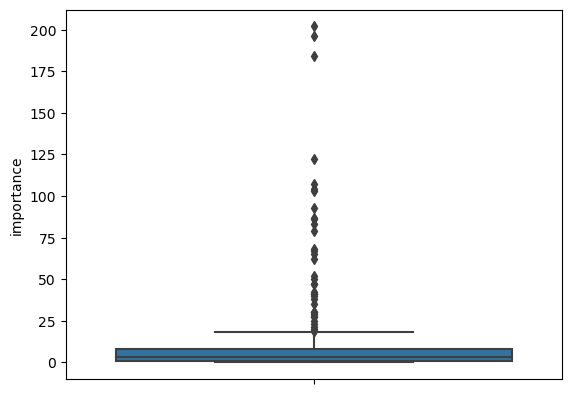

In [161]:
sns.boxplot(feature_importance_df,y='importance')

In [162]:
feature_importance_df.describe()

,importance
count,222.000000
mean,13.513514
std,30.426639
min,0.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,202.000000


In [163]:
feature_importance_df['importance'].median()

3.0

In [173]:
#filtro=feature_importance_df['importance']>feature_importance_df['importance'].median()
filtro=feature_importance_df['importance']>8

important_features=feature_importance_df.loc[filtro,'features']

In [170]:
len(important_features)

54

In [171]:
results_less_features=train_baseline(x_pre_processed.loc[:,important_features],y_train,models,RandomOverSampler())

Models: 100%|█████████████████████████████████████| 1/1 [01:02<00:00, 62.38s/it]


In [172]:
results_less_features


{'model': ['LGBM'],
 'scores': [{'accuracy': [0.6488831766672547,
    0.6446242114194031,
    0.6513247425278473,
    0.6467801280220427,
    0.6490314342836981],
   'precision': [0.0552560966922328,
    0.055287447875181556,
    0.055702981185302064,
    0.055936315033326266,
    0.05578625157202857],
   'recall': [0.5362986863332565,
    0.5439041253745103,
    0.53711387736284,
    0.5473611431205346,
    0.5418299147268956],
   'roc_auc': [0.6328248309562203,
    0.6344839316426378,
    0.6386419888317104,
    0.6366400426869143,
    0.6402139499858908]}]}

In [185]:
y_train_cat=one_hot_encoder.fit_transform(pd.DataFrame(y_train))

In [184]:
inputs=tf.keras.layers.Input(shape=len(important_features))
filters=[100,100,100]
x=inputs
for i in filters:
    x=tf.keras.layers.Dense(units=i,activation='relu')(x)
x=tf.keras.layers.Dense(units=2,activation='softmax')(x)
neural_model=tf.keras.Model(inputs=inputs,outputs=x)

In [186]:
neural_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 54)]              0         
                                                                 
 dense_10 (Dense)            (None, 100)               5500      
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 2)                 202       
                                                                 
Total params: 25902 (101.18 KB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [200]:
neural_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [201]:
neural_model.fit(x=x_pre_processed.loc[:,important_features],
                y=y_train_cat,epochs=100,validation_split=0.2)

Epoch 1/100


2023-11-27 06:22:07.770812: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205705008 exceeds 10% of free system memory.


14881/14881 [==============================] - 51s 3ms/step - loss: 0.1567 - accuracy: 0.9636 - val_loss: 0.1551 - val_accuracy: 0.9634
Epoch 2/100
14881/14881 [==============================] - 53s 4ms/step - loss: 0.1557 - accuracy: 0.9636 - val_loss: 0.1547 - val_accuracy: 0.9634
Epoch 3/100
14881/14881 [==============================] - 44s 3ms/step - loss: 0.1564 - accuracy: 0.9636 - val_loss: 0.1542 - val_accuracy: 0.9634
Epoch 4/100
14881/14881 [==============================] - 45s 3ms/step - loss: 0.1570 - accuracy: 0.9636 - val_loss: 0.1564 - val_accuracy: 0.9634
Epoch 5/100
 2371/14881 [===>..........................] - ETA: 44s - loss: 0.1574 - accuracy: 0.9631

KeyboardInterrupt: 

# - Redução Dimensionalidade

## - PCA


In [ ]:
pca = PCA(n_components=0.99)

In [ ]:
x_pre_processed_train, x_pre_processed_valid, y_train_ae, y_test_ae = train_test_split(x_pre_processed, 
                                                         y_train, test_size=0.33, random_state=42)

In [ ]:
pca.fit(x_pre_processed_train)

In [ ]:
x_pre_processed_train_pca=pca.transform(x_pre_processed_train)


In [ ]:
np.shape(x_pre_processed)

In [ ]:
np.shape(x_pre_processed_train_pca)

In [ ]:
results_pca_over=train_baseline(x_pre_processed_train_pca,y_train_ae,models,RandomUnderSampler())

In [ ]:
results_pca_over

## - AutoEncoder


In [ ]:
#Uso de autoencoder para reduzir dimensionalidade dos dados

In [ ]:
n_dimension=25
num_camadas=3

In [ ]:
final_n_neurons=np.shape(x_pre_processed)[-1]
final_n_neurons

In [ ]:
neurons_encoder=np.linspace(final_n_neurons,n_dimension,num_camadas).astype('int')
neurons_encoder

In [ ]:
neurons_decoder=neurons_encoder[-1::-1]

In [ ]:
neurons_decoder


In [ ]:
neurons_encoder=[80,50,30]
neurons_decoder=[50,80,94]

In [ ]:
patience     =50     #number of epochs with no improvement after which tranning will stop
lr_factor    =0.1    #factor by which the learning rate will be reduced. new_lr = lr * factor
lr_patience  =15     #number of epochs with no improvement after which learning rate will be reduced.
lr_min_delta =0.0001 #threshold for measuring the new optimum, to only focus on significant changes (min_delta).
lr_cooldown  =4     #number of epochs to wait before resuming normal operation after lr has been reduced.
lr_minimum   =0     #lower bound on the learning rate.

early_stop=EarlyStopping(monitor='val_loss',patience=patience,verbose=1,restore_best_weights=True) #early stopping

#Save the best model
#checkpoint = ModelCheckpoint(filepath_baseline,save_weights_only=False, monitor='mse', verbose=1,
#                             save_best_only=True, mode='max')

#Reduce the learning rate when the results are not improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=lr_patience,
                                mode='auto', verbose=1, min_delta=lr_min_delta,
                                 cooldown=lr_cooldown, min_lr=lr_minimum)

callbacks_list=[early_stop,reduce_lr]


In [ ]:
stacked_encoder=tf.keras.Sequential(
#[tf.keras.layers.BatchNormalization()]+
    [tf.keras.layers.Dense(n_neuron,activation='relu') for n_neuron in neurons_encoder])


stacked_decoder=tf.keras.Sequential(
[tf.keras.layers.Dense(n_neuron,activation='relu') for n_neuron in neurons_decoder])


stacked_ae=tf.keras.Sequential([stacked_encoder,stacked_decoder])
stacked_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

history=stacked_ae.fit(x_pre_processed_train,x_pre_processed_train,epochs=500,callbacks=callbacks_list,
                      validation_data=(x_pre_processed_valid,x_pre_processed_valid))

In [ ]:
pd.DataFrame(history.history).plot(xlabel='epoch')


# - Sampling

## - OverSampling

In [ ]:
#Aplicação de técnicas de oversampling para balancear o dataset. Através dessas técnicas serão criadas 
#novas amostras da classe minoritária


In [ ]:
#Técnicas de oversampling que serão testadas

#Random
os_random=RandomOverSampler()

#Smote
os_smote=SMOTE(sampling_strategy='auto',
                random_state=29,
                  k_neighbors=5)

#ADASYN
os_adasyn=ADASYN(sampling_strategy='auto',
                random_state=0,
                n_neighbors=5,
                n_jobs=4)

#BorderLine Smote
os_borderline_smote=BorderlineSMOTE(sampling_strategy='auto',
                                   k_neighbors=5,
                                   random_state=0,
                                    m_neighbors=10
                   )

#SVM SMOTE
os_svm_smote=SVMSMOTE(sampling_strategy='auto',
            random_state=0,
            k_neighbors=5,
            m_neighbors=10,
            svm_estimator=SVC(kernel='linear')
            )

oversampling_techniques={'Random' :os_random
                         ,'Smote'  :os_smote
                         ,'Adasyn':os_adasyn
                         ,'Borderline Smote':os_borderline_smote
                          #'SVM_Smote':os_svm_smote
                        }

results_over_sampling={}

In [ ]:
'''
for key in tqdm(oversampling_techniques.keys(),desc='Technique'):
    results_over_sampling[key]=train_model(LGBMClassifier(),x_pre_processed,y_train,scoring,
                                           sampler=oversampling_techniques[key])
'''

In [ ]:
#Salvar resultados
'''
with open('results_over_sampling.pkl', 'wb') as fp:
    pickle.dump(results_over_sampling, fp)
    print('dictionary saved successfully to file')
'''

In [ ]:
# Carregar resultados obtidos
'''
with open('results_over_sampling.pkl', 'rb') as fp:
    results_over_sampling = pickle.load(fp)
'''

In [ ]:
#results_over_sampling

In [ ]:
#O balanceamento do dataset com o uso de técnicas de oversampling não produziu melhioria nos
#resultados

## - UnderSampling

In [ ]:
#Balanceamento do dataset com o uso de diferentes técnicas de undersampling

In [ ]:
#Técnicas de undeersampling que serão testadas

#Random
us_random=RandomUnderSampler()

#Condensed Nearest Neighbours
us_cnn=CondensedNearestNeighbour(sampling_strategy='auto',
                random_state=29,
                n_neighbors =1)

#Tomek Links
us_tomek=TomekLinks(sampling_strategy='auto')

#One-Sided Selection
us_onesideselection=OneSidedSelection(sampling_strategy='auto',
                                   n_neighbors=1,
                                   random_state=0,
                   )

#Edited Nearest NEighbours
us_enn=EditedNearestNeighbours(
            sampling_strategy='auto',
            n_neighbors=3,
            kind_sel='all')

#Repeated Edited Nearest NEighbours
us_renn=RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='auto',
        max_iter=100)

#All KNN
us_allknn=AllKNN(sampling_strategy='auto',
                n_neighbors=3,
                kind_sel='all')

#Neighbourhood Cleaning Rule (NCR)
us_ncr=NeighbourhoodCleaningRule(
                sampling_strategy='auto',
                n_neighbors=3,
                kind_sel='all',
                threshold_cleaning=0.5)

undersampling_techniques={'Random' :us_random
                         #,'Condensed Nearest Neighbours':us_cnn
                         ,'Tomek Links':us_tomek
                         ,'One-Sided Selection':us_onesideselection
                         #,'Edited Nearest NEighbours':us_enn
                         ,'Repeated Edited Nearest NEighbours':us_renn
                         ,'All KNN':us_allknn
                         ,'Neighbourhood Cleaning Rule':us_ncr
                        }

results_under_sampling={}

In [ ]:
#for key in tqdm(undersampling_techniques.keys(),desc=key):
#    results_under_sampling[key]=train_model(LGBMClassifier(),x_pre_processed,y_train,scoring,
#                                           sampler=undersampling_techniques[key])

In [ ]:
#results_under_sampling

In [ ]:
#The application of different undersampling techniques did not improve the results.

## - Variational Autoencoders

In [ ]:
#Variational autoencoder será outra técnica que será empregada para gerar novas amostras para a classe minoritária

In [ ]:
class Sampling(tf.keras.layers.Layer):
    #This function will sample from a normal distribution (mean,var).
    #It returns s sample that has the same shape of log_var
    def call(self,inputs):
        mean,log_var=inputs
        return tf.random.normal(tf.shape(log_var))*tf.exp(log_var/2)+mean

In [ ]:
#Encoder
codings_size=10

n_neurons=np.arange(45,codings_size,-10)
input_shape=[np.shape(x_pre_processed)[1]]

inputs=tf.keras.layers.Input(shape=input_shape)
z=inputs
for i in n_neurons:
    z=tf.keras.layers.Dense(i,activation='relu')(z)
codings_mean=tf.keras.layers.Dense(codings_size)(z) #mean
codings_log_var=tf.keras.layers.Dense(codings_size)(z) #log_var
codings=Sampling()([codings_mean,codings_log_var])
variational_encoder=tf.keras.Model(inputs=[inputs],outputs=[codings_mean,codings_log_var,codings])

In [ ]:
variational_encoder.summary()

In [ ]:
#Decoder

decoder_inputs=tf.keras.layers.Input(shape=[codings_size])
z=decoder_inputs
for i in n_neurons[-1::-1]:
    z=tf.keras.layers.Dense(i,activation='relu')(z)
outputs=tf.keras.layers.Dense(input_shape[0])(z)
variational_decoder=tf.keras.Model(inputs=[decoder_inputs],outputs=[outputs])

In [ ]:
#Variational auto encoder model

_,_,codings=variational_encoder(inputs)
reconstructions=variational_decoder(codings)
variational_ae=tf.keras.Model(inputs=[inputs],outputs=[reconstructions])

In [ ]:
#Latent loss and reconstruction loss

latent_loss=-0.5*tf.reduce_sum( 1+codings_log_var-tf.exp(codings_log_var)-tf.square(codings_mean),axis=-1)
# tf.reduce_mean calculates the mean loss over all the instances in the batch
#The division by input_shape[0] is to garantee that the result has the appropriate 
#scale compared to the reconstruction loss
variational_ae.add_loss(tf.reduce_mean(latent_loss)/input_shape[0])

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
#Compiling the model

variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])


In [ ]:
#Separating samples from different classes.
#Getting all samples from the minority 
indexes_class_1=np.where(y_train==1)[0]

x_class_1=x_pre_processed.iloc[indexes_class_1]


In [ ]:
x_train_class_1,x_test_class_1=train_test_split(x_class_1,test_size=0.33,random_state=42)

In [ ]:
#Training the autoencoder using the samples from the minority class.
history=variational_ae.fit(x_train_class_1,x_train_class_1,epochs=500,batch_size=128,validation_data=[x_test_class_1,
                                                                                                    x_test_class_1])

In [ ]:
pd.DataFrame(history.history).plot(xlabel='epoch')

In [ ]:
n_splits=5
scores={'accuracy':[],'precision':[],'recall':[],'roc_auc':[]}
model_classifier=LGBMClassifier()
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
for train_index, test_index in skf.split(x_pre_processed, y_train):
    x_train,x_test=x_pre_processed.iloc[train_index],x_pre_processed.iloc[test_index]
    y_train_kfold,y_test=y_train.iloc[train_index],y_train.iloc[test_index]
    #A função generating_new_samples vai ser usada para criar novas samples da classe minoritária
    x_train,y_train_kfold=generating_new_samples(x_train,y_train_kfold,codings_size=codings_size,
                                                 auto_encoder=variational_ae,decoder=variational_decoder)
    model_classifier.fit(x_train,y_train_kfold)
    y_pred_proba=model_classifier.predict_proba(x_test)
    y_pred=np.argmax(y_pred_proba,axis=1)
    scores['accuracy']=scores['accuracy']  +[accuracy_score(y_test,y_pred)]
    scores['precision']=scores['precision']+[precision_score(y_test,y_pred)]
    scores['recall']=scores['recall']      +[recall_score(y_test,y_pred)]
    scores['roc_auc']=scores['roc_auc']    +[roc_auc_score(y_test,y_pred_proba[:,1])]

In [ ]:
scores


In [ ]:
#The creation of new samples using an autoencoder did not improve the results.